In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import cv2
import copy
from sklearn.metrics import confusion_matrix


cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
from torch.autograd import Variable
from PIL import Image
toTensor = transforms.ToTensor()

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cpu')

In [5]:
t_loss = []
v_loss = []

actual = []
pred = []
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
#                     outputs = outputs.cpu()
#                     index = outputs.data.numpy().argmax()
#                     pred.append(index)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                t_loss.append(epoch_loss)
            else:
                v_loss.append(epoch_loss)
                
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

Epoch 0/0
----------
train Loss: 0.1224 Acc: 0.9505
val Loss: 0.0368 Acc: 0.9957

Training complete in 6m 0s
Best val Acc: 0.995714


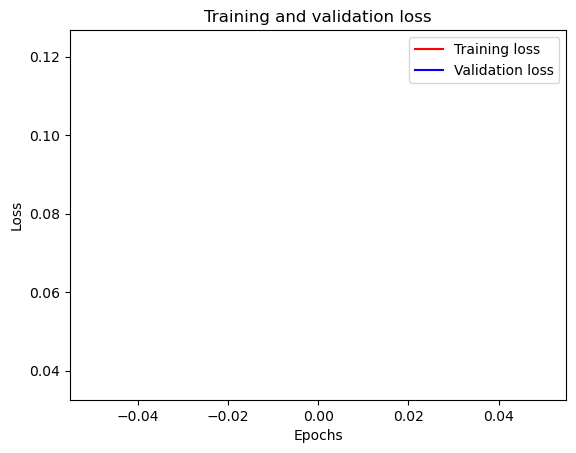

In [8]:
plt.plot( t_loss, 'r', label='Training loss')
plt.plot(v_loss, 'b', label='Validation loss')

# plt.plot(best_epoch_train_loss, 'g', label='Best loss')
# plt.plot( train_loss_arr, 'r', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
torch.save(model_ft.state_dict(), 'best_model/model01_resnet18.pt')

In [11]:
# model_ft = models.resnet18(pretrained=True)
# model_ft.load_state_dict(torch.load('best_model/model01_resnet18.pt'))
                         
model_state_dict = torch.load('best_model/model01_resnet18.pt', map_location=torch.device('cpu'))  # cpu only

# model_state_dict = torch.load('best_model/model01_resnet18.pt')
#

model_ft = models.resnet18(pretrained=False)

num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft.load_state_dict(model_state_dict)
model_ft = model_ft.to(device)
model_ft.eval()

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
def Prediction(image_path):
    image = Image.open(image_path)
    image_tensor = toTensor(image)
    image_tensor = image_tensor.float()
    
    image_tensor = image_tensor.unsqueeze_(0)
    image_tensor.to(device)
       
    input = Variable(image_tensor).to(device)

    output = model_ft(input)
    output = output.cpu()
    index = output.data.numpy().argmax()
    
    pred = class_names[index]
    
    return pred

In [13]:
Prediction("demo_img/7129235.png")

'Not_Signature_card'

In [14]:
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_dataset = datasets.ImageFolder('dataset/test', transform=val_transforms)

valloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

In [15]:
true_labels = []
pred_labels = []

with torch.no_grad():
    for images, labels in valloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

cm = confusion_matrix(true_labels, pred_labels)
cm

array([[200,   0],
       [  0, 200]], dtype=int64)

In [16]:
tp = cm[0, 0]
fp = cm[1, 0]
fn = cm[0, 1]
tn = cm[1, 1]

# Calculate precision, recall, and F1 score
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision.item())
print("Recall:", recall.item())
print("F1 Score:", f1_score.item())

print(tp)
print(fp)
print(fn)
print(tn)

Precision: 1.0
Recall: 1.0
F1 Score: 1.0
200
0
0
200


In [17]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

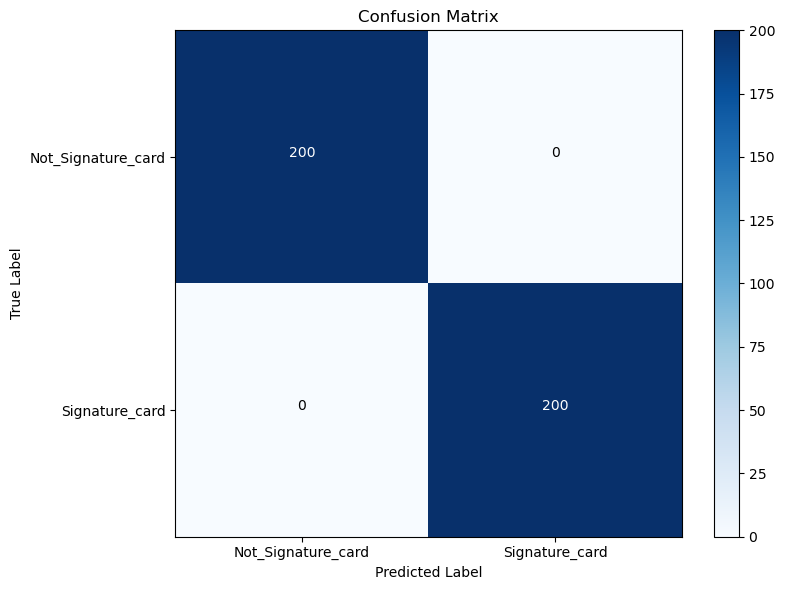

In [18]:
# Example confusion matrix values
confusion_matrix = np.array([[50, 10], [15, 75]])
classes = class_names

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes, normalize=False)
plt.show()

In [21]:
real_label = []
pred_label = []

def evaluate(model, data_loader):
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
#             inputs = FaceCrop(inputs)
#             image_tensor = toTensor(inputs)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            real_label.append(labels.cpu().numpy())
            pred_label.append(predicted.cpu().numpy())
    return correct / total

transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([255,255])
])

tests_path = r'dataset/test'

test_dataloader = DataLoader(
    torchvision.datasets.ImageFolder(tests_path, transform = transformer),
    batch_size = 50
)

In [22]:
accuracy = evaluate(model_ft, test_dataloader)
accuracy

0.8475